# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [77]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [79]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [80]:
df.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


In [81]:
df=df.replace('?',np.nan)

In [82]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [83]:
df['other_diagnosis_codes'][0]

'?|?'

In [84]:
df=df.replace('?|?',np.nan)

In [85]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [86]:
len(df)

143424

In [87]:
df['encounter_id'].nunique()

101766

In [88]:
df['patient_nbr'].nunique()

71518

In [89]:
df.shape

(143424, 26)

In [90]:
df['admission_type_id'].unique()

array([6, 1, 2, 3, 4, 5, 8, 7])

In [91]:
df['ndc_code'][0]

nan

In [92]:
type(df['ndc_code'][0])

float

In [93]:
type(df['weight'][0])

float

In [94]:
type(df['weight'])

pandas.core.series.Series

In [95]:
type(df['admission_type_id'])

pandas.core.series.Series

In [96]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

In [97]:
#dat = pd.DataFrame({'A': [1,2,3], 'B': [True, False, False], 'C': [1, 2, 3]})

In [98]:
#dat

In [99]:
#dat.drop([0 , 2], inplace=True)

In [100]:
#dat

In [101]:
#dat['A']=dat['A'].replace(2,np.nan).replace(3,0).replace(1,0)

In [102]:
#dat

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:??
The dataset is at line level and needs to be converted to encounter level. It should be aggrgated on encounter id , patient number and principal diagnosis code.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


In [103]:
#part a: Missing and zero values 
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df

In [104]:
null_df = check_null_values(df)
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


In [105]:
#part b: Histogram plots of numerical features

num_feature_list=['weight','number_outpatient','number_inpatient','number_emergency','num_lab_procedures','number_diagnoses','num_medications','num_procedures']

In [106]:
df['weight'].unique()

array([nan, '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

(array([1.4144e+05, 1.5000e+03, 2.7600e+02, 1.2800e+02, 2.9000e+01,
        2.2000e+01, 9.0000e+00, 2.0000e+00, 1.3000e+01, 5.0000e+00]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

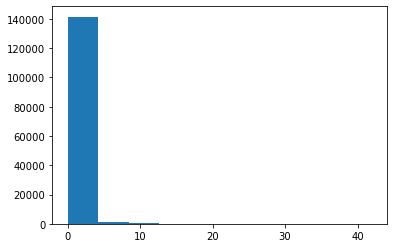

In [107]:
plt.hist(df['number_outpatient'])

(array([1.34319e+05, 6.59200e+03, 1.62800e+03, 5.13000e+02, 2.21000e+02,
        9.50000e+01, 3.60000e+01, 1.50000e+01, 2.00000e+00, 3.00000e+00]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

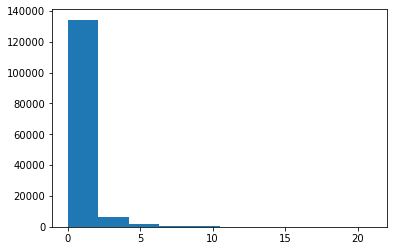

In [108]:
plt.hist(df['number_inpatient'])

(array([1.43132e+05, 2.32000e+02, 4.30000e+01, 6.00000e+00, 3.00000e+00,
        1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([ 0. ,  7.6, 15.2, 22.8, 30.4, 38. , 45.6, 53.2, 60.8, 68.4, 76. ]),
 <a list of 10 Patch objects>)

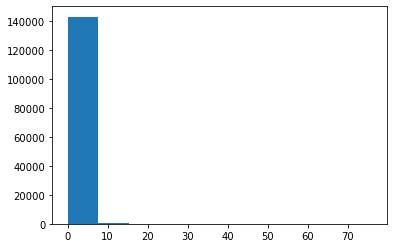

In [109]:
plt.hist(df['number_emergency'])

(array([1.4461e+04, 1.3772e+04, 3.0647e+04, 3.9583e+04, 2.9159e+04,
        1.2683e+04, 2.6990e+03, 3.8200e+02, 3.2000e+01, 6.0000e+00]),
 array([  1. ,  14.1,  27.2,  40.3,  53.4,  66.5,  79.6,  92.7, 105.8,
        118.9, 132. ]),
 <a list of 10 Patch objects>)

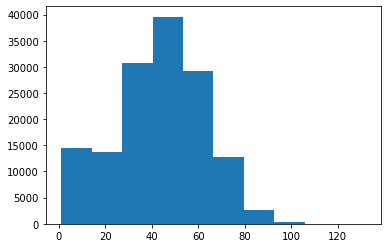

In [110]:
plt.hist(df['num_lab_procedures'])

(array([1.6280e+03, 3.9160e+03, 2.4106e+04, 1.4170e+04, 3.0020e+04,
        6.9427e+04, 3.9000e+01, 1.0000e+01, 3.0000e+01, 7.8000e+01]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

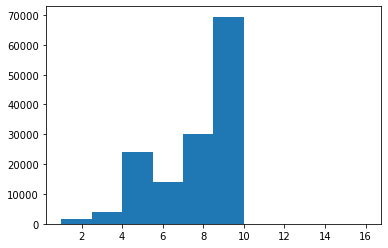

In [111]:
plt.hist(df['number_diagnoses'])

(array([1.8388e+04, 6.2033e+04, 4.1642e+04, 1.4657e+04, 4.2480e+03,
        1.4390e+03, 6.3700e+02, 2.9500e+02, 7.1000e+01, 1.4000e+01]),
 array([ 1.,  9., 17., 25., 33., 41., 49., 57., 65., 73., 81.]),
 <a list of 10 Patch objects>)

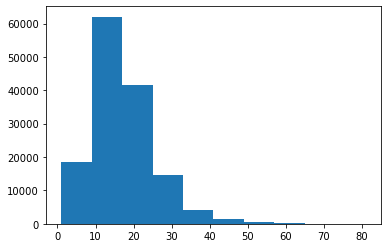

In [112]:
plt.hist(df['num_medications'])

(array([65788., 29039.,     0., 17788.,     0., 13252.,  5951.,     0.,
         4329.,  7277.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

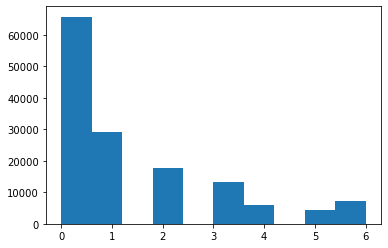

In [113]:
plt.hist(df['num_procedures'])

In [114]:
#part c: Cardinality

cat_feature_list=['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','payer_code','medical_specialty','primary_diagnosis_code','other_diagnosis_codes','ndc_code','max_glu_serum','A1Cresult','change','readmitted']

def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
   
    #add feature with high cardinality
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

val_df = count_unique_values(df, cat_feature_list) 
val_df

,columns,cardinality
race,race,5
gender,gender,3
age,age,10
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716
other_diagnosis_codes,other_diagnosis_codes,19373


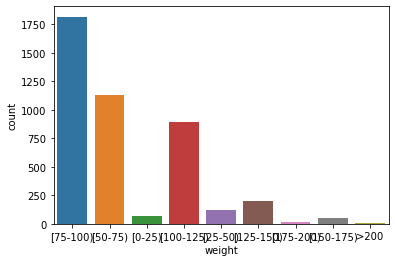

In [115]:
ax = sns.countplot(x="weight", data=df)

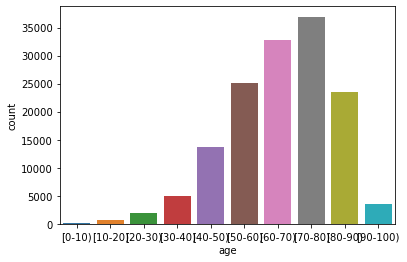

In [116]:
# part d: Demographic analysis


ax = sns.countplot(x="age", data=df)

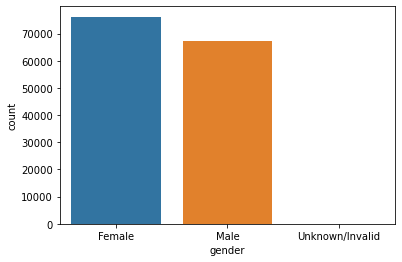

In [117]:
ax = sns.countplot(x="gender", data=df)

In [118]:
df.groupby('gender').agg('count')

,encounter_id,patient_nbr,race,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
gender,,,,,,,,,,,,,,,,,,,,,,,,,
Female,76185,76185,74548,76185,2167,76185,76185,76185,76185,47499,39628,76176,76019,76185,76185,76185,76185,76185,76185,76185,63236,76185,76185,76185,76185
Male,67234,67234,65565,67234,2135,67234,67234,67234,67234,41732,34331,67210,67060,67234,67234,67234,67234,67234,67234,67234,56722,67234,67234,67234,67234
Unknown/Invalid,5,5,2,5,0,5,5,5,5,3,2,5,5,5,5,5,5,5,5,5,4,5,5,5,5


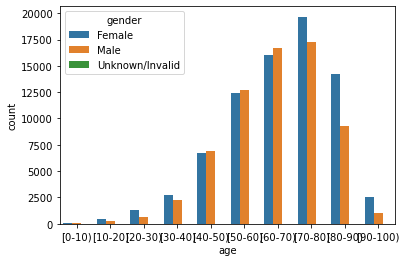

In [119]:
ax = sns.countplot(x="age", hue="gender", data=df)

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [120]:
######NOTE: The visualization will only display in Chrome browser. ########
# import tensorflow_data_validation as tfdv
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [121]:
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [122]:
df.ndc_code.dtypes

dtype('O')

In [123]:
df.ndc_code[1]

'68071-1701'

In [124]:
df.ndc_code.nunique()

251

In [125]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [126]:
ndc_code_df.head(20)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
5,0093-7212,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
6,0093-7267,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
7,0093-7455,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
8,0093-7456,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
9,0093-7457,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug


In [127]:
ndc_code_df.NDC_Code.nunique()

267

In [128]:
len(ndc_code_df)

269

In [129]:
ndc_code_df.isnull().sum()

NDC_Code                0
Proprietary Name        0
Non-proprietary Name    0
Dosage Form             2
Route Name              5
Company Name            2
Product Type            2
dtype: int64

In [130]:
vc=ndc_code_df.NDC_Code.value_counts()
vc[vc > 1]

0781-5635    2
0781-5634    2
Name: NDC_Code, dtype: int64

In [131]:
ndc_code_df.index[ndc_code_df['NDC_Code'] == '0781-5634'].tolist()

[150, 263]

In [132]:
ndc_code_df.index[ndc_code_df['NDC_Code'] == '0781-5635'].tolist()

[151, 264]

In [133]:
ndc_code_df.drop([150 , 151], inplace=True)

In [134]:
len(ndc_code_df)

267

In [135]:
from student_utils import reduce_dimension_ndc

In [136]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [137]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [138]:
reduce_dim_df.ndc_code.nunique()

251

In [139]:
#reduce_dim_df['ndc_code'] = reduce_dim_df['ndc_code'].map(ndc_code_df.set_index('NDC_Code')['Non-proprietary Name'])

In [140]:
reduce_dim_df['generic_drug_name'] = reduce_dim_df['ndc_code'].map(ndc_code_df.set_index('NDC_Code')['Non-proprietary Name'])

In [141]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide


In [142]:
reduce_dim_df.generic_drug_name.nunique()

22

In [143]:
len(reduce_dim_df)==len(df)

True

In [144]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print('Successful reduction')

Successful reduction


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [145]:
# from student_utils import select_first_encounter
# first_encounter_df = select_first_encounter(reduce_dim_df)

In [146]:
def select_first_encounter(df, patient_id, encounter_id):
    df = df.sort_values(encounter_id)
    last_encounter_values = df.groupby(patient_id)[encounter_id].head(1).values
    return df[df[encounter_id].isin(last_encounter_values)]

In [147]:
first_encounter_df = select_first_encounter(reduce_dim_df, "patient_nbr", "encounter_id" )

In [148]:
first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human
11,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,Glipizide
14,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Human Insulin
13,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,0173-0863,None,None,Ch,NO,Rosiglitazone Maleate
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide


In [149]:
first_encounter_df.shape

(101754, 27)

In [158]:
first_encounter_df.generic_drug_name.nunique()

21

In [159]:
first_encounter_df.generic_drug_name.unique()

array(['Insulin Human', 'Glipizide', 'Human Insulin',
       'Rosiglitazone Maleate', 'Glyburide', 'Repaglinide',
       'Metformin Hydrochloride', 'Glimepiride', nan, 'Acarbose',
       'Tolbutamide', 'Tolazamide', 'Pioglitazone', 'Metformin Hcl',
       'Pioglitazone Hydrochloride And Glimepiride',
       'Glyburide-metformin Hydrochloride', 'Nateglinide',
       'Glyburide And Metformin Hydrochloride', 'Miglitol',
       'Glipizide And Metformin Hydrochloride',
       'Glipizide And Metformin Hcl',
       'Pioglitazole And Metformin Hydrochloride'], dtype=object)

In [150]:
reduce_dim_df[reduce_dim_df['patient_nbr']==48330783].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
11,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,Glipizide
12,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human


In [151]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [152]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]


In [153]:
def aggregate_dataset(df, grouping_field_list,  array_field):
    df = df.groupby(grouping_field_list)['encounter_id', 
            array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={
    0: array_field + "_array"}) 
    
    dummy_df = pd.get_dummies(df[array_field + '_array'].apply(pd.Series).stack()).sum(level=0)
    dummy_col_list = [x.replace(" ", "_") for x in list(dummy_df.columns)] 
    mapping_name_dict = dict(zip([x for x in list(dummy_df.columns)], dummy_col_list ) ) 
    concat_df = pd.concat([df, dummy_df], axis=1)
    new_col_list = [x.replace(" ", "_") for x in list(concat_df.columns)] 
    concat_df.columns = new_col_list

    return concat_df, dummy_col_list

In [154]:
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glyburide',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Nateglinide',
 'Pioglitazone',
 'Repaglinide',
 'Rosiglitazone_Maleate']

In [156]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate
0,88792836,100654011,Caucasian,Female,[70-80),[75-100),3,3,1,10,UN,Surgery-General,715,402|428,1,3,1,65,9,28,1,0049-4110,None,None,Ch,<30,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
1,88792836,100654011,Caucasian,Female,[70-80),[75-100),3,3,1,10,UN,Surgery-General,715,402|428,1,3,1,65,9,28,1,68071-1701,None,None,Ch,<30,[Human Insulin],0,0,0,0,1,0,0,0,0,0,0,0
2,88986678,58682736,Caucasian,Male,[80-90),[50-75),1,11,5,6,UN,Family/GeneralPractice,250.2,780|403,0,0,0,73,9,16,0,68071-1701,None,None,No,NO,[Human Insulin],0,0,0,0,1,0,0,0,0,0,0,0
3,89032962,69250302,Caucasian,Male,[60-70),[100-125),1,1,7,2,CP,Cardiology,414,411|401,0,0,0,58,9,12,3,0781-5422,None,None,No,>30,[Pioglitazone],0,0,0,0,0,0,0,0,0,1,0,0
4,89277516,30950811,Caucasian,Male,[50-60),[100-125),3,1,1,2,BC,Surgery-General,196,199|250,0,0,0,5,7,11,4,0093-8342,None,None,No,>30,[Glyburide],0,0,0,1,0,0,0,0,0,0,0,0


In [157]:
agg_drug_df.shape

(862, 39)

In [96]:
len(agg_drug_df)

862

In [97]:
agg_drug_df['patient_nbr'].nunique()

589

In [98]:
agg_drug_df['encounter_id'].nunique()

589

In [99]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()
print('Success')

AssertionError: 

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: ??

In [ ]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
# required_demo_col_list = ['race', 'gender', 'age']
# student_categorical_col_list = [ "feature_A", "feature_B", .... ] + required_demo_col_list + ndc_col_list
# student_numerical_col_list = [ "feature_A", "feature_B", .... ]
# PREDICTOR_FIELD = ''

In [ ]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [ ]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [ ]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [ ]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [ ]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

In [ ]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

In [ ]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

In [ ]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

In [ ]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

In [ ]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

In [ ]:
# Training partition
show_group_stats_viz(d_train, 'gender')

In [ ]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [ ]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [ ]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [ ]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [ ]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

In [ ]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [ ]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [ ]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [ ]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [ ]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [ ]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [ ]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [ ]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [ ]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [ ]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [ ]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
prob_output_df.head()

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [ ]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [ ]:
# AUC, F1, precision and recall
# Summary

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [ ]:
# Reference group fairness plot